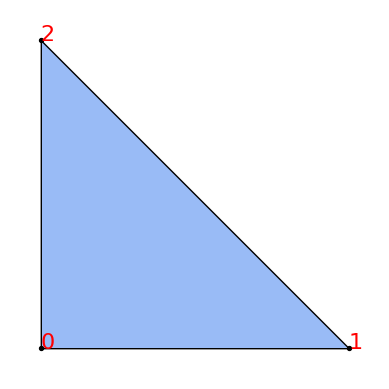

In [15]:
from fealpy.mesh import TriangleMesh
mesh = TriangleMesh.from_one_triangle()

import matplotlib.pyplot as plt
fig = plt.figure()
axes = fig.gca()
mesh.add_plot(axes)
mesh.find_node(axes, showindex=True, 
               color='k', marker='o', markersize=8, fontsize=16, fontcolor='r')
plt.show()

In [16]:
p = 3 # 基函数的次数
from fealpy.functionspace import LagrangeFESpace
space = LagrangeFESpace(mesh, p=p, spacetype='C', doforder='vdims')
ldof = space.number_of_local_dofs()
print("ldof:", ldof)
GD = mesh.geo_dimension()
print("GD:", GD)
TD = mesh.top_dimension()
print("TD:", TD)

ldof: 10
GD: 2
TD: 2


### 三角形单元上的插值点

#### 1.多重指标向量

In [17]:
multiIndex = mesh.multi_index_matrix(p=p, etype=2) # (ldof, LNN)
print("multiIndex:", multiIndex.shape, "\n", multiIndex)

multiIndex: (10, 3) 
 [[3 0 0]
 [2 1 0]
 [2 0 1]
 [1 2 0]
 [1 1 1]
 [1 0 2]
 [0 3 0]
 [0 2 1]
 [0 1 2]
 [0 0 3]]


In [18]:
import numpy as np
ldof = (p+1) * (p+2) // 2
idx = np.arange(0, ldof) 
idx0 = np.floor((-1 + np.sqrt(1 + 8*idx)) / 2)
multiIndex = np.zeros((ldof, 3), dtype=np.int_) 
multiIndex[:, 2] = idx - idx0 * (idx0 + 1) / 2
multiIndex[:, 1] = idx0 - multiIndex[:, 2]
multiIndex[:, 0] = p - multiIndex[:, 1] - multiIndex[:, 2]
print("multiIndex:", multiIndex.shape, "\n", multiIndex)

multiIndex: (10, 3) 
 [[3 0 0]
 [2 1 0]
 [2 0 1]
 [1 2 0]
 [1 1 1]
 [1 0 2]
 [0 3 0]
 [0 2 1]
 [0 1 2]
 [0 0 3]]


bc: (10, 3) 
 [[1.         0.         0.        ]
 [0.66666667 0.33333333 0.        ]
 [0.66666667 0.         0.33333333]
 [0.33333333 0.66666667 0.        ]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.         0.66666667]
 [0.         1.         0.        ]
 [0.         0.66666667 0.33333333]
 [0.         0.33333333 0.66666667]
 [0.         0.         1.        ]]
points: (1, 10, 2) 
 [[[0.         0.        ]
  [0.33333333 0.        ]
  [0.         0.33333333]
  [0.66666667 0.        ]
  [0.33333333 0.33333333]
  [0.         0.66666667]
  [1.         0.        ]
  [0.66666667 0.33333333]
  [0.33333333 0.66666667]
  [0.         1.        ]]]


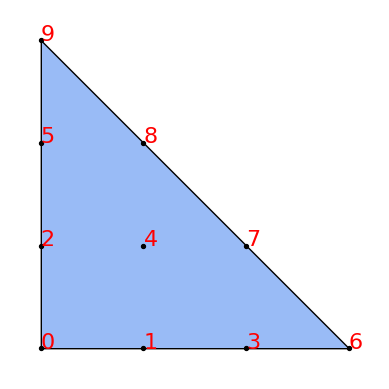

In [19]:
bc = multiIndex / p # 插值点的重心坐标 (ldof, LNN)
print("bc:", bc.shape, "\n", bc)
node = mesh.entity('node') 
cell = mesh.entity('cell') 

import numpy as np
points = np.einsum('ij, cjk -> cik', 
                   bc, node[cell]) # 插值点的笛卡尔几何坐标 (1, ldof, GD)
print("points:", points.shape, "\n", points)
fig = plt.figure()
axes = fig.gca()
mesh.add_plot(axes)
mesh.find_node(axes, node=points[0], showindex=True, 
               color='k', marker='o', markersize=8, fontsize=16, fontcolor='r')
plt.show()

### 三角形单元上的积分点

bcs: (10, 3) 
 [[0.88887189 0.05556405 0.05556405]
 [0.05556405 0.88887189 0.05556405]
 [0.05556405 0.05556405 0.88887189]
 [0.29553371 0.63421075 0.07025554]
 [0.29553371 0.07025554 0.63421075]
 [0.07025554 0.29553371 0.63421075]
 [0.63421075 0.29553371 0.07025554]
 [0.63421075 0.07025554 0.29553371]
 [0.07025554 0.63421075 0.29553371]
 [0.33333333 0.33333333 0.33333333]]
points: (1, 10, 2) 
 [[[0.05556405 0.05556405]
  [0.88887189 0.05556405]
  [0.05556405 0.88887189]
  [0.63421075 0.07025554]
  [0.07025554 0.63421075]
  [0.29553371 0.63421075]
  [0.29553371 0.07025554]
  [0.07025554 0.29553371]
  [0.63421075 0.29553371]
  [0.33333333 0.33333333]]]


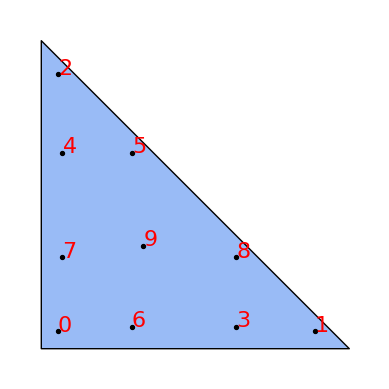

In [25]:
qf = mesh.integrator(4)
bcs, ws = qf.get_quadrature_points_and_weights() # 积分点的重心坐标和权重
print("bcs:", bcs.shape, "\n", bcs)

node = mesh.entity('node') 
cell = mesh.entity('cell') 

import numpy as np
points = np.einsum('ij, cjk -> cik', 
                   bcs, node[cell]) # 插值点的笛卡尔几何坐标 (1, ldof, GD)
print("points:", points.shape, "\n", points)
fig = plt.figure()
axes = fig.gca()
mesh.add_plot(axes)
mesh.find_node(axes, node=points[0], showindex=True, 
               color='k', marker='o', markersize=8, fontsize=16, fontcolor='r')
plt.show()

### 三角形单元上基函数在插值点的值

In [20]:
c = np.arange(1, p+1) 
P = 1.0 / np.multiply.accumulate(c) 
t = np.arange(0, p) 
multiIndex = mesh.multi_index_matrix(p=p, etype=2) # (ldof, LNN)
bc = multiIndex / p 
node = mesh.entity('node') 
cell = mesh.entity('cell') 
points = np.einsum('ij, cjk -> cik', bc, node[cell])

shape = bc.shape[:-1] + (p+1, TD+1) 
A = np.ones(shape, dtype=np.float64)
A[:, 1:, :] = p * bc[:, np.newaxis, :] - t.reshape(-1, 1) 
print("A:", A.shape, "\n", A)

A: (10, 4, 3) 
 [[[ 1.  1.  1.]
  [ 3.  0.  0.]
  [ 2. -1. -1.]
  [ 1. -2. -2.]]

 [[ 1.  1.  1.]
  [ 2.  1.  0.]
  [ 1.  0. -1.]
  [ 0. -1. -2.]]

 [[ 1.  1.  1.]
  [ 2.  0.  1.]
  [ 1. -1.  0.]
  [ 0. -2. -1.]]

 [[ 1.  1.  1.]
  [ 1.  2.  0.]
  [ 0.  1. -1.]
  [-1.  0. -2.]]

 [[ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 0.  0.  0.]
  [-1. -1. -1.]]

 [[ 1.  1.  1.]
  [ 1.  0.  2.]
  [ 0. -1.  1.]
  [-1. -2.  0.]]

 [[ 1.  1.  1.]
  [ 0.  3.  0.]
  [-1.  2. -1.]
  [-2.  1. -2.]]

 [[ 1.  1.  1.]
  [ 0.  2.  1.]
  [-1.  1.  0.]
  [-2.  0. -1.]]

 [[ 1.  1.  1.]
  [ 0.  1.  2.]
  [-1.  0.  1.]
  [-2. -1.  0.]]

 [[ 1.  1.  1.]
  [ 0.  0.  3.]
  [-1. -1.  2.]
  [-2. -2.  1.]]]


In [21]:
B = np.cumprod(A, axis=-2)
B[:, 1:, :] *= P.reshape(-1, 1)
print("B:", B.shape, "\n", B)

B: (10, 4, 3) 
 [[[ 1.  1.  1.]
  [ 3.  0.  0.]
  [ 3. -0. -0.]
  [ 1.  0.  0.]]

 [[ 1.  1.  1.]
  [ 2.  1.  0.]
  [ 1.  0. -0.]
  [ 0. -0.  0.]]

 [[ 1.  1.  1.]
  [ 2.  0.  1.]
  [ 1. -0.  0.]
  [ 0.  0. -0.]]

 [[ 1.  1.  1.]
  [ 1.  2.  0.]
  [ 0.  1. -0.]
  [-0.  0.  0.]]

 [[ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 0.  0.  0.]
  [-0. -0. -0.]]

 [[ 1.  1.  1.]
  [ 1.  0.  2.]
  [ 0. -0.  1.]
  [-0.  0.  0.]]

 [[ 1.  1.  1.]
  [ 0.  3.  0.]
  [-0.  3. -0.]
  [ 0.  1.  0.]]

 [[ 1.  1.  1.]
  [ 0.  2.  1.]
  [-0.  1.  0.]
  [ 0.  0. -0.]]

 [[ 1.  1.  1.]
  [ 0.  1.  2.]
  [-0.  0.  1.]
  [ 0. -0.  0.]]

 [[ 1.  1.  1.]
  [ 0.  0.  3.]
  [-0. -0.  3.]
  [ 0.  0.  1.]]]


In [22]:
# 计算每个基函数在每个插值点的值
idx = np.arange(TD + 1) 
phi = np.prod(B[:, multiIndex, idx], axis=-1)
phi = phi[:, np.newaxis, :] # (ldof, 1m ldof)
print("phi:", phi.shape, "\n", phi)

phi: (10, 1, 10) 
 [[[ 1.  0.  0. -0.  0. -0.  0. -0. -0.  0.]]

 [[ 0.  1.  0.  0.  0. -0. -0.  0. -0.  0.]]

 [[ 0.  0.  1. -0.  0.  0.  0. -0.  0. -0.]]

 [[-0.  0.  0.  1.  0. -0.  0.  0. -0.  0.]]

 [[-0.  0.  0.  0.  1.  0. -0.  0.  0. -0.]]

 [[-0.  0.  0. -0.  0.  1.  0. -0.  0.  0.]]

 [[ 0. -0. -0.  0.  0. -0.  1.  0. -0.  0.]]

 [[ 0. -0. -0.  0.  0.  0.  0.  1.  0. -0.]]

 [[ 0. -0. -0.  0.  0.  0. -0.  0.  1.  0.]]

 [[ 0. -0. -0. -0.  0.  0.  0. -0.  0.  1.]]]
